In [1]:
import numpy as np
from doepy import build
from concurrent.futures import ThreadPoolExecutor  # or ProcessPoolExecutor if you want to use multiple processes
import requests  # or any library to make network calls
import json
import random
from sklearn.linear_model import LinearRegression 
import seaborn as sns

In [2]:
doe = build.full_fact(
{'CPU':[.5,4,32],
'Memory':[248, 1024, 1024*16],
'NodeType':["GPU1", "GPU2", "GPU3"]}
)
doe['i'] = doe.index + 1
doe

/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU3' has dtype incompatible with float32, please 

,CPU,Memory,NodeType,i
0,0.5,248.0,0.0,1
1,4.0,248.0,0.0,2
2,32.0,248.0,0.0,3
3,0.5,1024.0,0.0,4
4,4.0,1024.0,0.0,5
5,32.0,1024.0,0.0,6
6,0.5,16384.0,0.0,7
7,4.0,16384.0,0.0,8
8,32.0,16384.0,0.0,9
9,0.5,248.0,1.0,10


In [3]:
def getConfigResults(row):
    url = f"https://jsonplaceholder.typicode.com/posts/{int(row.i)}"
    response = requests.get(url)
    data = json.loads(response.text)
    random.seed(data['id'])
    return random.random()*30

def applyThreaded(df, func, max_workers):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(func, df.itertuples(index=False)))

    df['results'] = results
    return df

In [4]:
applyThreaded(doe, getConfigResults, 4)

,CPU,Memory,NodeType,i,results
0,0.5,248.0,0.0,1,4.030927
1,4.0,248.0,0.0,2,28.681028
2,32.0,248.0,0.0,3,7.138939
3,0.5,1024.0,0.0,4,7.081443
4,4.0,1024.0,0.0,5,18.687051
5,32.0,1024.0,0.0,6,23.800203
6,0.5,16384.0,0.0,7,9.714983
7,4.0,16384.0,0.0,8,6.801176
8,32.0,16384.0,0.0,9,13.890221
9,0.5,248.0,1.0,10,17.142078


In [5]:
doe

,CPU,Memory,NodeType,i,results
0,0.5,248.0,0.0,1,4.030927
1,4.0,248.0,0.0,2,28.681028
2,32.0,248.0,0.0,3,7.138939
3,0.5,1024.0,0.0,4,7.081443
4,4.0,1024.0,0.0,5,18.687051
5,32.0,1024.0,0.0,6,23.800203
6,0.5,16384.0,0.0,7,9.714983
7,4.0,16384.0,0.0,8,6.801176
8,32.0,16384.0,0.0,9,13.890221
9,0.5,248.0,1.0,10,17.142078


In [6]:
lm=LinearRegression()
X = doe[['CPU','Memory','NodeType']]
Y = doe['results']
lm.fit(X,Y)

LinearRegression()

In [7]:
lm.predict(X)

array([13.313119, 13.351085, 13.654806, 13.118271, 13.156237, 13.459958,
        9.261488,  9.299454,  9.603174, 16.84926 , 16.887224, 17.190947,
       16.654411, 16.692377, 16.996098, 12.797628, 12.835594, 13.139315,
       20.385399, 20.423365, 20.727087, 20.190552, 20.228518, 20.532238,
       16.333769, 16.371735, 16.675455], dtype=float32)

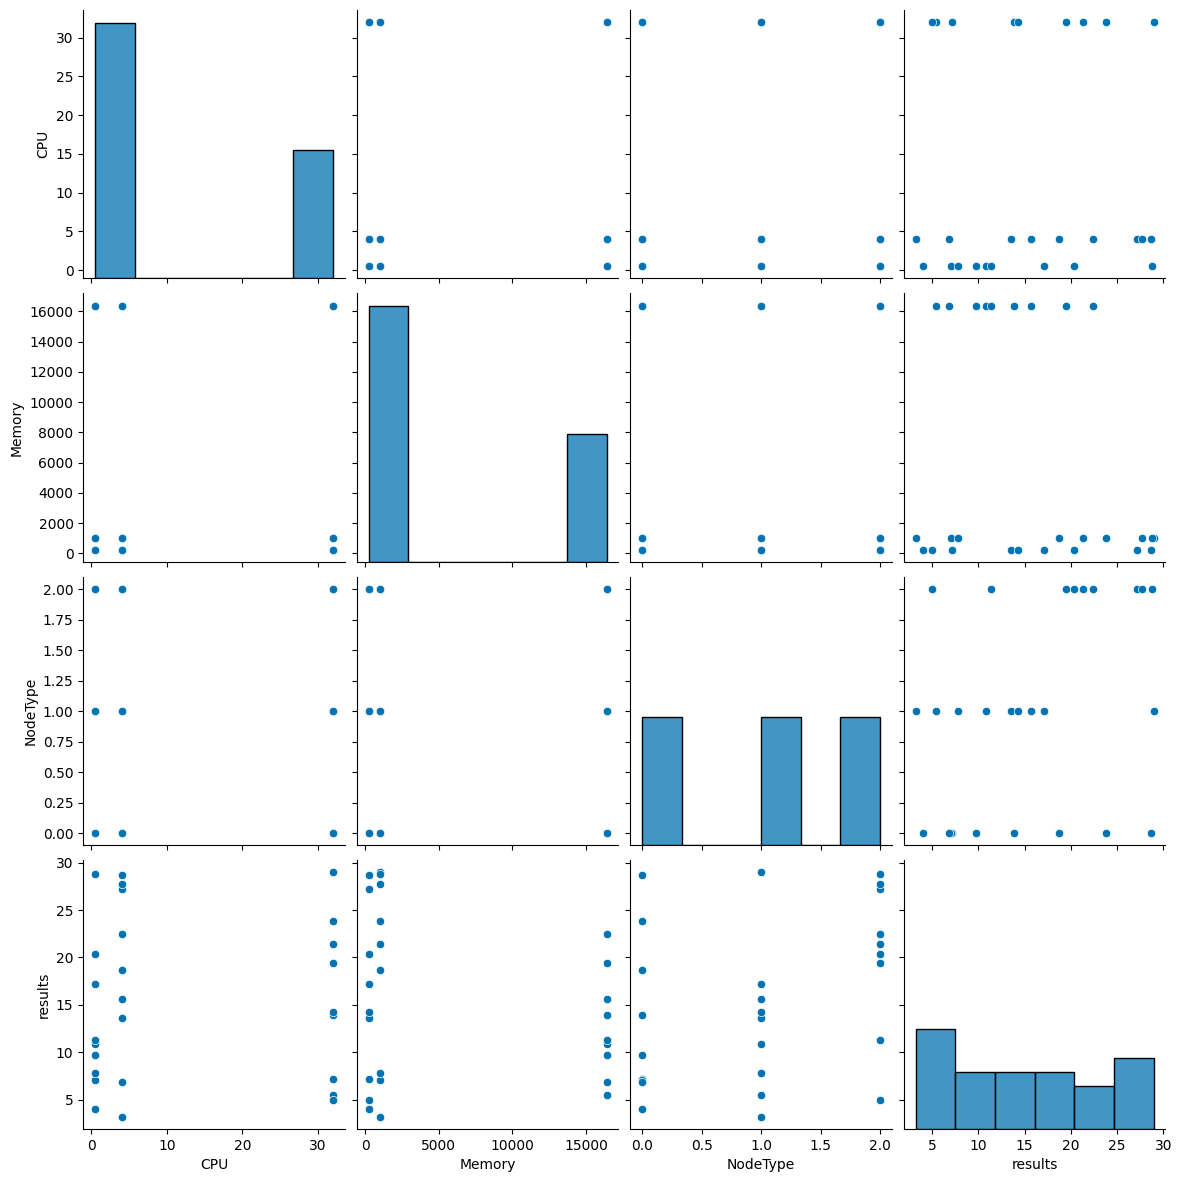

In [11]:
sns.set_palette('colorblind')
sns.pairplot(data=doe[['CPU', "Memory", "NodeType", "results"]], height=3)